### Get from WANDB

In [31]:
import wandb
from tqdm import tqdm
import shutil
project = 'node_effect'
# group = 'eval'

In [32]:
shutil.rmtree('./results/ll_models')
api = wandb.Api()
runs = api.runs(f'{project}', filters={"state": "finished"})
print(runs)

<Runs cybershiptrooper/node_effect>


In [33]:
files_to_download = ['results.csv', 'metric_collection.log', 'train_args.log', 'results_kl_div.csv', 'results_accuracy.csv']
print("Downloading files for runs")
import concurrent.futures

def download_files(run):
    for file in run.files():
        if any([file.name.endswith(ftd) for ftd in files_to_download]):
            file.download(replace=True)

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(download_files, runs), total=len(runs)))

100%|██████████| 120/120 [01:22<00:00,  1.45it/s]


### Read Files

In [1]:
bad_runs = ['38', '16', # these are constant runs
            '35', '37'# '4', # these are runs for which I haven't saved the model on wandb for one of siit or iit
]

In [2]:
import os
os.listdir('results/ll_models')

['35',
 '34',
 '33',
 '18',
 '11',
 '16',
 '19',
 '8',
 '21',
 '38',
 '36',
 '37',
 '24',
 '4',
 '3',
 '13']

In [3]:
import dataframe_image as dfi

def make_image(results_dict, folder, run, kl_div=False):
    # remove unnamed columns from results
    images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
    if make_image and not os.path.exists(images_path):
        dfi.export(results_dict[run], images_path)

In [4]:
import pandas as pd

def walk_wandb_dir_and_get_results(weight: float = 510, make_image: bool = True):
    def drop_bad_columns_and_make_image(df, folder, kl_div=False):
        df.drop(columns=[c for c in df.columns if 'Unnamed' in c], inplace=True)
        if make_image:
            images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
            dfi.export(df, images_path)
        return df
    
    results = {}
    results_kl_div = {}
    for run in os.listdir('./results/ll_models/'):
        folder = os.path.join('./results/ll_models/', run, f'results_{weight}')
        result = os.path.join(folder, 'results.csv')
        result_accuracy = os.path.join(folder, 'results_accuracy.csv')
        result_kl_div = os.path.join(folder, 'results_kl_div.csv')
        if os.path.exists(result):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result), folder, kl_div=False)
        elif os.path.exists(result_accuracy):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result_accuracy), folder, kl_div=False)
        if os.path.exists(result_kl_div):
            results_kl_div[run] = drop_bad_columns_and_make_image(pd.read_csv(result_kl_div), folder, kl_div=True)
    return results, results_kl_div

In [5]:
results, results_kl = walk_wandb_dir_and_get_results()
results_tracr, results_kl_tracr = walk_wandb_dir_and_get_results(weight="tracr", make_image=False)
results_iit, results_kl_iit = walk_wandb_dir_and_get_results(weight="110", make_image=True)

In [6]:
for run in bad_runs:
    results.pop(run, None)
    results_kl.pop(run, None)
    results_tracr.pop(run, None)
    results_kl_tracr.pop(run, None)
    results_iit.pop(run, None)
    results_kl_iit.pop(run, None)

### Make DF

In [7]:
from circuits_benchmark.utils.get_cases import get_cases
from utils.node_effect_utils import *
from utils.plotter import plot_results_in_box_plot, plot_results_in_scatter_plot

In [8]:
df_combined, df_combined_tracr = make_combined_df(results, results_tracr)
df_combined_kl, df_combined_kl_tracr = make_combined_df(results_kl, results_kl_tracr)
df_combined_iit, df_combined_tracr_iit = make_combined_df(results_iit, results_tracr)
df_combined_kl_iit, df_combined_kl_tracr_iit = make_combined_df(results_kl_iit, results_kl_tracr)

Unique runs: ['34', '33', '11', '19', '8', '21', '36', '24', '4', '3', '13']
Unique runs: ['34', '33', '11', '19', '8', '21', '36', '24', '13']
Unique runs: ['34', '33', '11', '19', '8', '21', '36', '24', '4', '3', '13']
Unique runs: ['34', '33', '11', '19', '8', '21', '36', '24', '13']


In [9]:
unique_runs = list(df_combined_tracr['run'].unique()) # GLOBAL!!!
# remove 38, 16 from from dataframes
# iit_unique_runs
print(f"Unique runs: {unique_runs}")
all_cases = get_cases(indices=unique_runs)
for case in all_cases:
    case.get_tracr_output()

Unique runs: ['34', '33', '11', '19', '8', '21', '36', '24', '4', '3', '13']


In [10]:
df_combined, df_combined_tracr = make_combined_df(results, results_tracr)
df_combined_kl, df_combined_kl_tracr = make_combined_df(results_kl, results_kl_tracr)
df_combined_iit, df_combined_tracr_iit = make_combined_df(results_iit, results_tracr)
df_combined_kl_iit, df_combined_kl_tracr_iit = make_combined_df(results_kl_iit, results_kl_tracr)
remove_nodes_with_zero_effect(df_combined, df_combined_tracr, df_combined_kl, df_combined_kl_tracr, cases=all_cases)
remove_nodes_with_zero_effect(df_combined_iit, df_combined_tracr_iit, df_combined_kl_iit, df_combined_kl_tracr_iit, cases=all_cases)

Unique runs: ['34', '33', '11', '19', '8', '21', '36', '24', '4', '3', '13']
Unique runs: ['34', '33', '11', '19', '8', '21', '36', '24', '13']
Unique runs: ['34', '33', '11', '19', '8', '21', '36', '24', '4', '3', '13']
Unique runs: ['34', '33', '11', '19', '8', '21', '36', '24', '13']
Run 8 has node blocks.0.attn.hook_result, head  0 with zero effect and in circuit
Removing node blocks.0.attn.hook_result, head  0 from IIT circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Run 8 has node blocks.0.attn.hook_result, head  0 with zero effect and in circuit
Removing node blocks.0.attn.hook_result, head  0 from IIT circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8
Removing node blocks.0.attn.hook_result, head  0 from KL circuit in run 8


In [11]:
# df_combined_kl.groupby('run').get_group('11')

### Box Plots

In [12]:
set(results.keys()) - set(results_iit.keys())

{'18'}

In [13]:
results_tracr.keys(), results.keys(), results_iit.keys()

(dict_keys(['34', '33', '11', '19', '8', '21', '36', '24', '4', '3', '13']),
 dict_keys(['34', '33', '18', '11', '19', '8', '21', '36', '4', '3', '13']),
 dict_keys(['34', '33', '11', '19', '8', '21', '36', '4', '3', '13']))

Strict

Run 19 does not have not_in_circuit


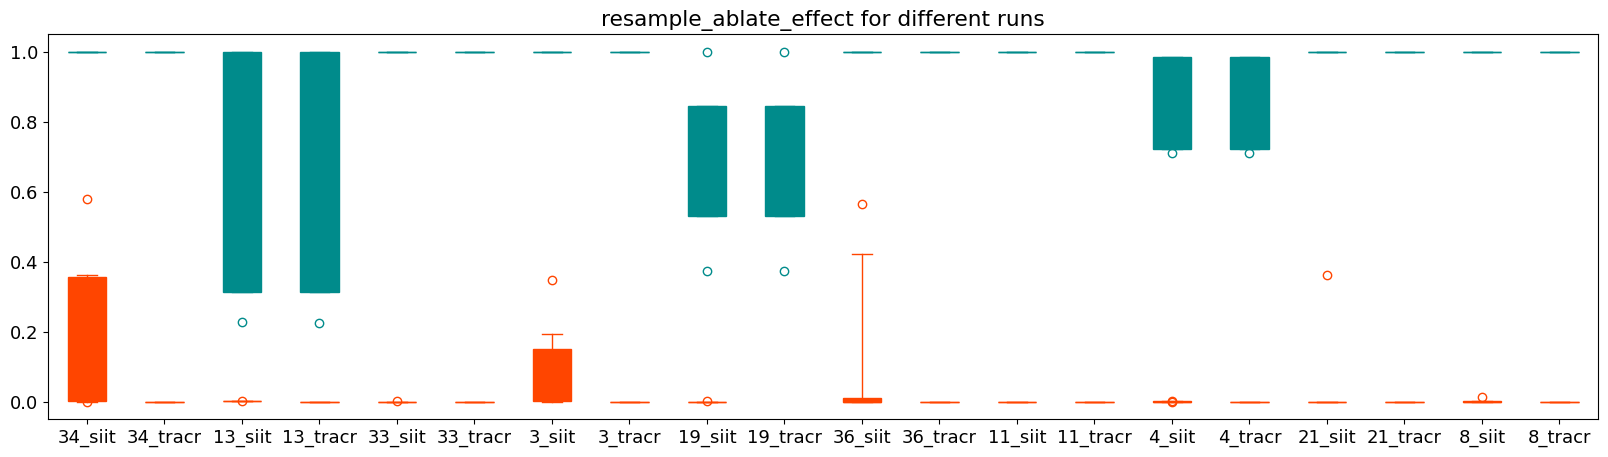

In [14]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
                        key = "resample_ablate_effect",
                        normalize_by_runs=False)

Run 19 does not have not_in_circuit


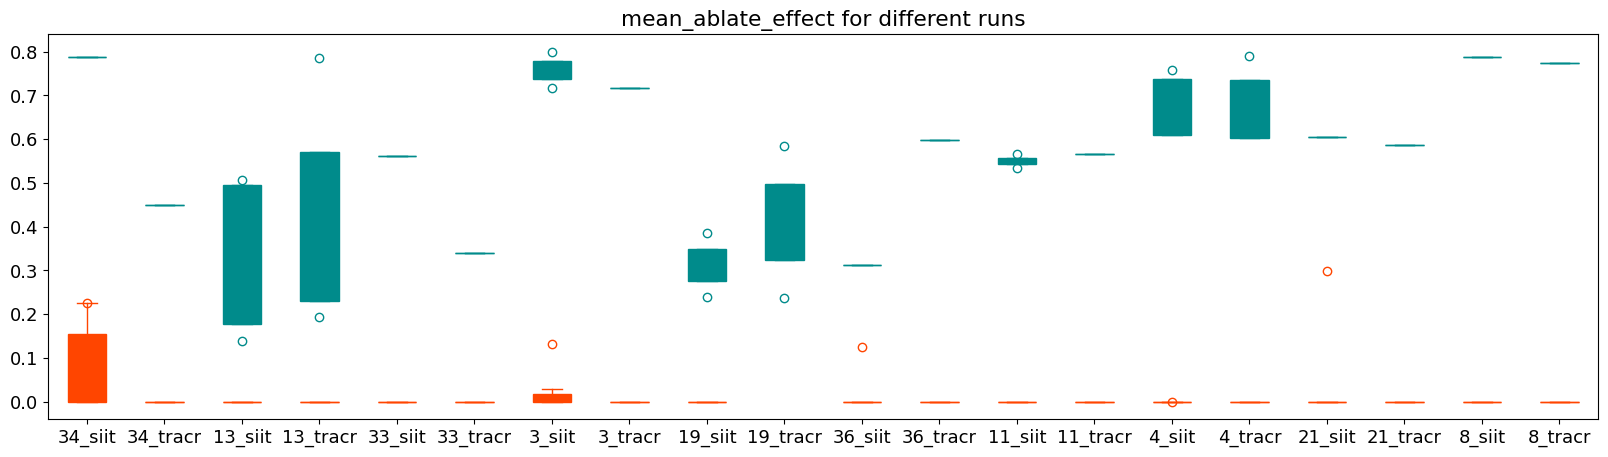

In [15]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
             key = "mean_ablate_effect",
             normalize_by_runs=False)

Run 19 does not have not_in_circuit


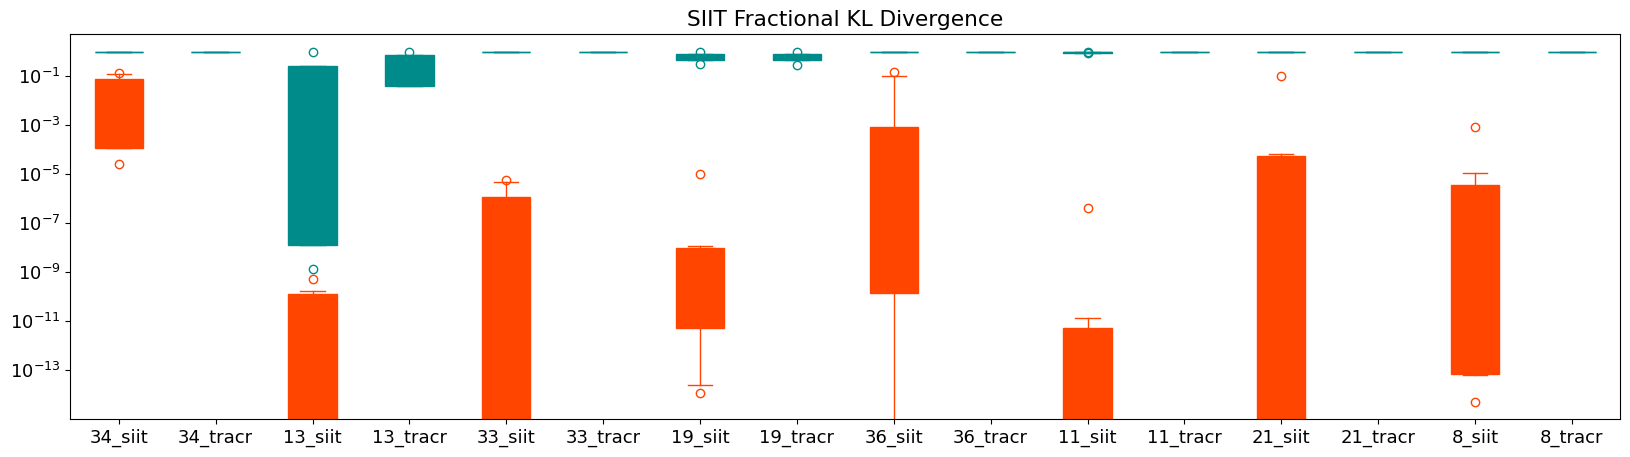

In [16]:
plot_results_in_box_plot(df_combined_kl, df_combined_kl_tracr, 
             key = "resample_ablate_effect",
             title="SIIT Fractional KL Divergence",
             normalize_by_runs=True,
             plot_y_log=True)

IIT

Run 19 does not have not_in_circuit
Run 19 does not have not_in_circuit


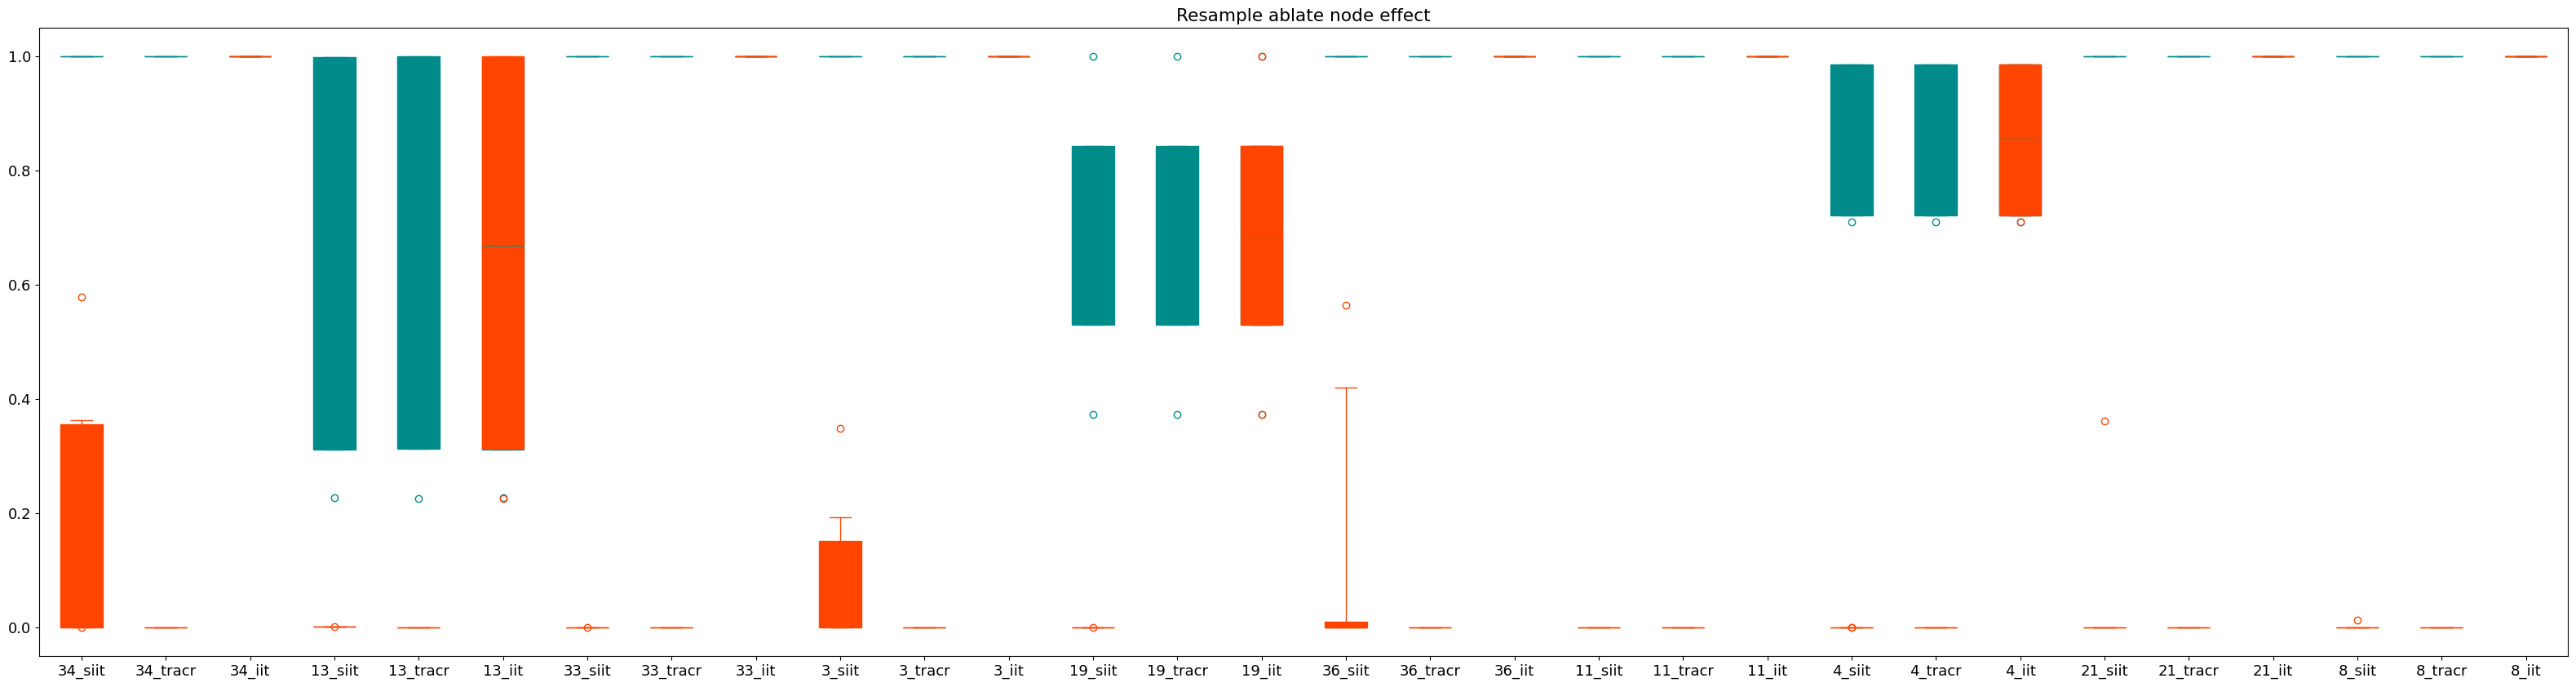

In [17]:
plot_results_in_box_plot(df_combined, df_combined_tracr, 
             df_iit=df_combined_iit,
             key = "resample_ablate_effect",
             title = "Resample ablate node effect",
             normalize_by_runs=False, 
             figsize=(40, 10))

In [24]:
# plot_results_in_box_plot(df_combined, df_combined_tracr,
#              df_iit=df_combined_iit,
#              key = "mean_ablate_effect",
#              title = "Mean ablate node effect",
#              normalize_by_runs=False,
#              figsize=(40, 10))

In [23]:
# plot_results_in_box_plot(df_combined_kl, df_combined_kl_tracr,
#              df_iit=df_combined_kl_iit,
#              key = "resample_ablate_effect",
#              title="Fractional KL Divergence",
#              normalize_by_runs=True,
#             plot_y_log=True,
#             figsize=(40, 10))

### Scatter

In [19]:
# plot_results_in_scatter_plot(df_combined, df_combined_tracr,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 title="SIIT vs TRACR resample ablate effect",
#                 mean=True)

Run 19 does not have not_in_circuit
[0.9999999999999368, 0.6416721029783914, 0.9999999999999368, 0.9999999999999996, 0.6863983346434651, 0.9999999999999368, 1.0, 0.8516066534586193, 1.0, 1.0] [0.9999999999999368, 0.6411948583822882, 0.9999999999999368, 0.9999999999999996, 0.6863983346434651, 0.9999999999999368, 0.9999999999999368, 0.8516066534586177, 0.9999999999999368, 0.9999999999999368] [0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0] [0.25053536412899563, 0.0016550457713428333, 0.1111111380419603, 0.21787919960393928, 0.16413821836473394, 0.1890352605890244, 0.12748049682176954, 0.03772272161409055, 0.22456332161373846, 0.1111111111111041]
10 10


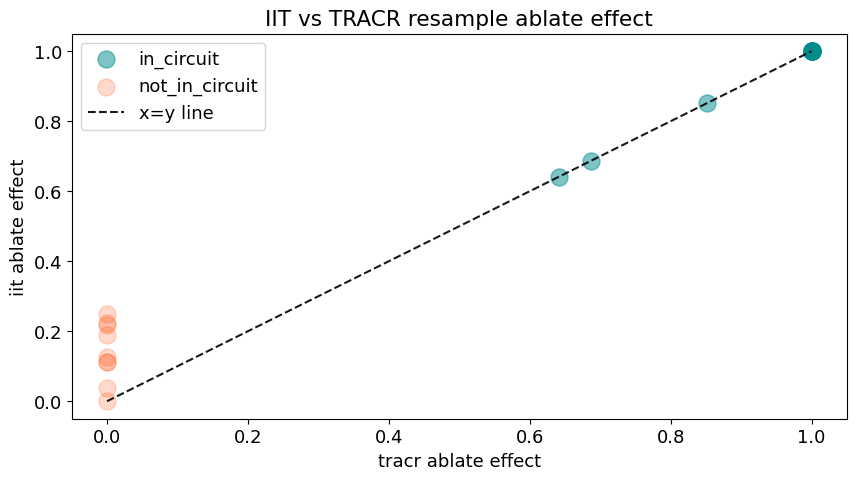

In [20]:
plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs TRACR resample ablate effect",
                mean=True)

In [21]:
# plot_results_in_scatter_plot(df_combined, df_combined_tracr,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 title="SIIT vs TRACR resample ablate effect",
#                 mean=False)

In [22]:
# plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
#                 all_cases=all_cases,
#                 key = "resample_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 title="IIT vs TRACR resample ablate effect",
#                 mean=False)

[0.9999999999999368, 0.6411932363790154, 0.9999999999999368, 0.9999999999999996, 0.6863988540600106, 0.9999999999999368, 1.0, 0.8516066534586177, 1.0, 1.0] [0.9999999999999368, 0.6411948583822882, 0.9999999999999368, 0.9999999999999996, 0.6863983346434651, 0.9999999999999368, 0.9999999999999368, 0.8516066534586177, 0.9999999999999368, 0.9999999999999368] [0.2047239563745461, 0.0016189334366709669, 4.916071865867041e-06, 0.10620629496079521, 7.72731635602546e-06, 0.11107163042016627, 0.0, 2.6801570337615134e-05, 0.040091275763517356, 0.0014946442620427222] [0.25053536412899563, 0.0016550457713428333, 0.1111111380419603, 0.21787919960393928, 0.16413821836473394, 0.1890352605890244, 0.12748049682176954, 0.03772272161409055, 0.22456332161373846, 0.1111111111111041]
10 10


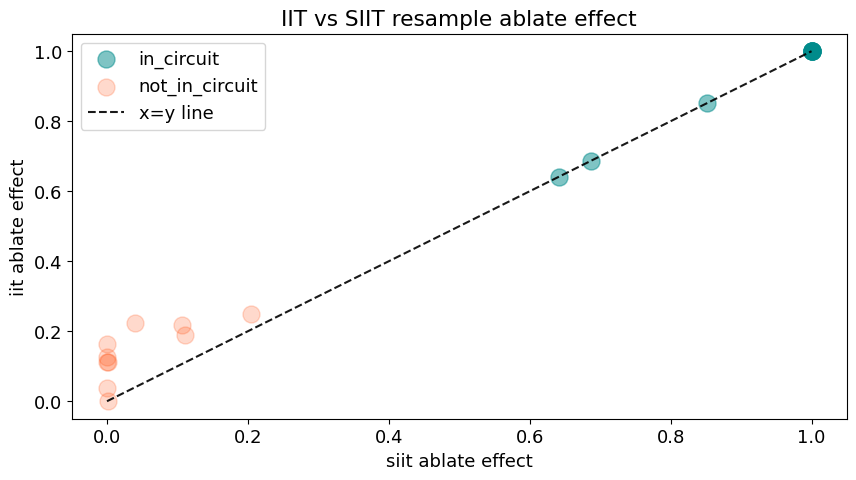

In [21]:
plot_results_in_scatter_plot(df_combined_iit, df_combined,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs SIIT resample ablate effect",
                mean=True,
                xlabel="siit ablate effect",
                ylabel="iit ablate effect",
                both_iit=True)


[0.9999999999999368, 0.227374332949931, 0.9988696693473456, 0.3396592738714397, 0.9988696693473456, 0.9999999999999368, 0.9999999999999996, 0.9999999999999996, 0.9999999999999368, 0.3727977081200843, 0.9999999999999368, 1.0, 1.0, 0.9851929165418152, 0.7101729559026326, 0.7258678248482082, 0.9851929165418152, 1.0, 1.0] [0.9999999999999368, 0.2273776607403042, 0.998869669347339, 0.3396624340941708, 0.998869669347339, 0.9999999999999368, 0.9999999999999996, 0.9999999999999996, 0.9999999999999368, 0.3727966692869934, 0.9999999999999368, 0.9999999999999368, 0.9999999999999368, 0.9851929165418152, 0.7101729559026326, 0.7258678248482082, 0.9851929165418152, 0.9999999999999368, 0.9999999999999368] [0.0, 9.563871910616637e-06, 6.211090913659115e-05, 0.0274289096597408, 0.2173530996119585, 0.5782617370074153, 0.3562692492317802, 0.3004133305537715, 0.3627176065252014, 0.0016188418601002, 0.0016188418601002, 0.0016190269294115, 0.0016188418601002, 0.0016188418601002, 0.0016192062502135, 0.0, 0.0,

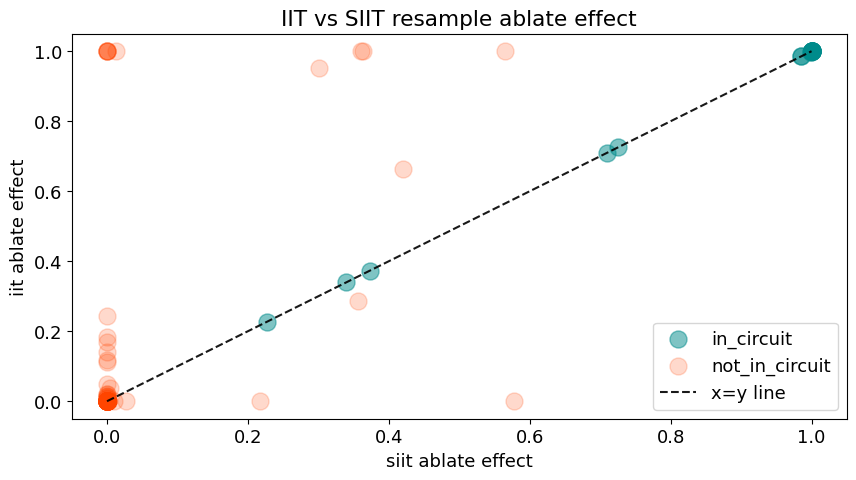

In [26]:
plot_results_in_scatter_plot(df_combined_iit, df_combined,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs SIIT resample ablate effect",
                mean=False,
                xlabel="siit ablate effect",
                ylabel="iit ablate effect",
                both_iit=True)

In [33]:
(df_combined[df_combined["resample_ablate_effect"] > 0.5]).groupby('status').get_group('not_in_circuit')

,node,status,resample_ablate_effect,mean_ablate_effect,run
5,"blocks.1.attn.hook_result, head 1",not_in_circuit,0.578262,0.153589,34
20,"blocks.0.attn.hook_result, head 0",not_in_circuit,0.649262,0.608126,18
25,"blocks.1.attn.hook_result, head 1",not_in_circuit,0.866284,0.086925,18
78,blocks.1.mlp.hook_post,not_in_circuit,0.564689,0.000000,36


[0.7876124916995358, 0.1394250593198373, 0.5065148146029353, 0.1886863186922682, 0.4915761480789915, 0.560727900995469, 0.7999999993749999, 0.715624999440918, 0.3854062765405733, 0.2388297900059099, 0.3118020599972995, 0.564688846756477, 0.5343042831910604, 0.6080670553887094, 0.7313269258647798, 0.7578692452278089, 0.6080670553887094, 0.6048019932920792, 0.7875942884775373] [0.7876264782724204, 0.139590289966043, 0.4701367945569152, 0.1973973978457066, 0.4420261601843501, 0.2451316734974423, 0.7999999993749999, 0.7140624994421386, 0.3854062765405733, 0.2375227780710419, 0.5618065526022193, 0.7869962832598858, 0.7869962832598858, 0.6080670553887094, 0.7563249277731646, 0.7191887784910239, 0.6080670553887094, 0.6001028716528128, 0.4369471305835358] [0.0, 0.0, 0.0, 0.0008391943730737, 3.3967391291079326e-05, 0.153589154351673, 0.2256401853337222, 0.2246717150655558, 0.1120370443935022, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.

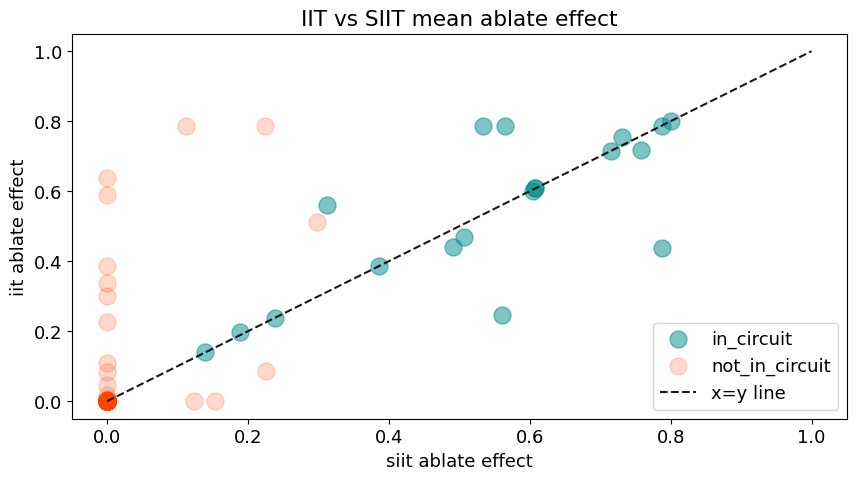

In [27]:
plot_results_in_scatter_plot(df_combined_iit, df_combined,
                all_cases=all_cases,
                key = "mean_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs SIIT mean ablate effect",
                mean=False,
                xlabel="siit ablate effect",
                ylabel="iit ablate effect",
                both_iit=True)

[1.0, 0.227374332949931, 0.9988696693473456, 0.3396592738714397, 0.9988696693473456, 1.0, 1.0, 1.0, 0.9999999999999996, 0.9999999999999996, 1.0] [0.9999999999999368, 0.2273776607403042, 0.998869669347339, 0.3396624340941708, 0.998869669347339, 0.9999999999999368, 0.9999999999999368, 0.9999999999999368, 0.9999999999999996, 0.9999999999999996, 0.9999999999999368] [0.0, 0.0, 0.0, 0.3608214818716562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016188418601002, 0.0016188418601002, 0.0016190269294115, 0.0016188418601002, 0.0016188418601002, 0.0016192062502135, 0.0, 0.0, 0.0, 0.3608214818716562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0.0, 1.6526879073005065e-06, 0.000135657165834, 0.0, 0.0, 0.0002556910299634, 0.0, 0.0130587974746798, 0.0] [0.0, 0.0, 0.0, 0.9996299231814242, 0.0, 0.021439971342285, 0.0, 0.0, 0.9999999999999368, 0.0016188418601002, 0.0016188418601002, 0.0016188418601002, 0.0016188418601002, 0.0016188418601002, 0.001836065327556, 0.0, 0.0, 0.0, 0.

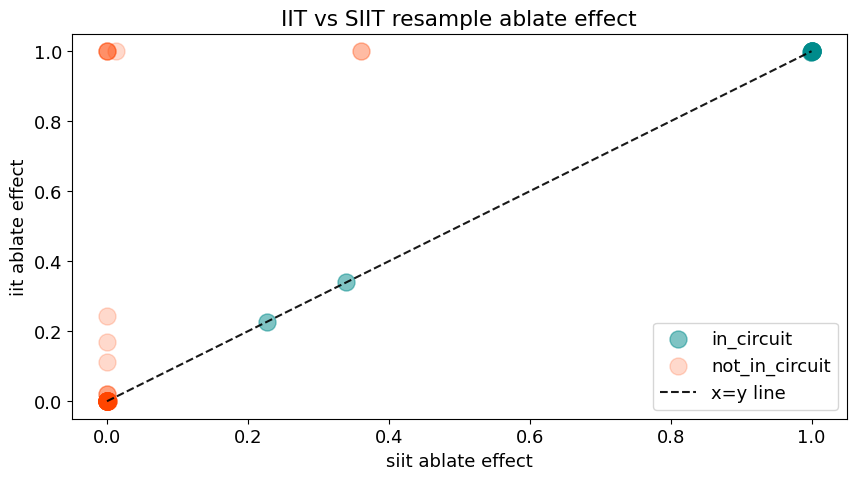

In [23]:
plot_results_in_scatter_plot(df_combined_iit, df_combined,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                title="IIT vs SIIT resample ablate effect",
                mean=False,
                xlabel="siit ablate effect",
                ylabel="iit ablate effect",
                both_iit=True)


### Other Plots

Run 19 does not have not_in_circuit
[0.41082880424067586, 0.7858847503319311, 0.564688846756477, 0.5858061689464517, 0.4299501614656697, 0.3386846625912774, 0.7858847503319311, 0.67726882381257, 0.598319698896762, 0.450053948033654, 0.715624999440918, 0.7746834587412101] [0.3121180332732416, 0.7869675108813788, 0.5494965649737686, 0.6048019932920792, 0.3315505851735081, 0.560727900995469, 0.775353660182598, 0.6763325704675018, 0.3118020599972995, 0.7876124916995358, 0.7578124994079589, 0.7875942884775373] [nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.12077847483908109, 0.0, 0.033053460235792934, 0.0, 0.0, 0.17047687546612542, 1.1655477403801724e-06, 0.013726485626159612, 0.07964569565653533, 0.024776785694928815, 0.0]
12 12


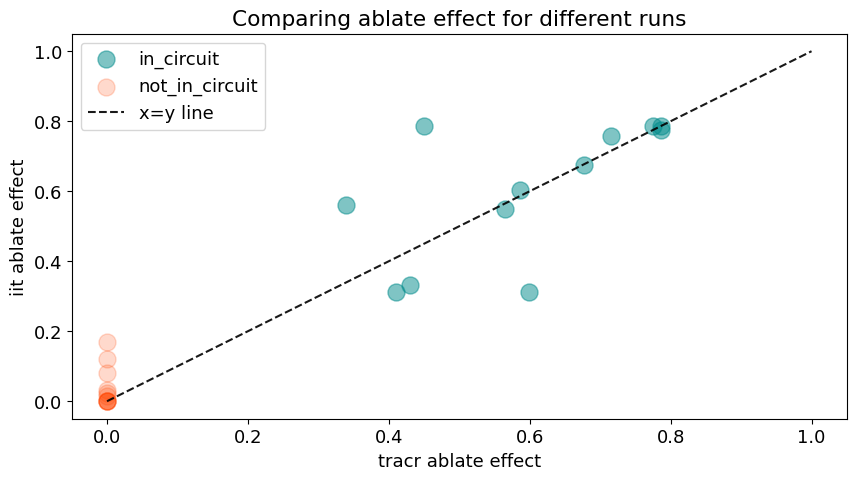

In [57]:
plot_results_in_scatter_plot(df_combined, df_combined_tracr,
                all_cases=all_cases,
                key = "mean_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=False,
                mean=True)

In [59]:
# plot_results_in_scatter_plot(df_combined_iit, df_combined_tracr_iit,
#                 all_cases=all_cases,
#                 key = "mean_ablate_effect",
#                 normalize_by_runs=False,
#                 plot_minmax_lines=False,
#                 mean=False)

Run 19 does not have not_in_circuit
[0.6469628037270874, 1.0, 1.0, 1.0, 1.0, 0.43732731645159273, 1.0, 1.0, 1.0, 1.0] [0.6478038447010848, 1.0, 0.9209635680528216, 1.0, 1.0, 0.25000001788320003, 0.5578598626532558, 1.0, 1.0, 1.0] [nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0013136612860038671] [1.2813987792365573e-06, 0.13832331714732995, 4.9837972132738054e-08, 0.011667642177189318, 1.3234408261789535e-06, 1.0945779659928683e-10, 0.14474207791859658, 0.027600306306788034, 0.04767762615234629, 9.453256759098651e-05]
10 10


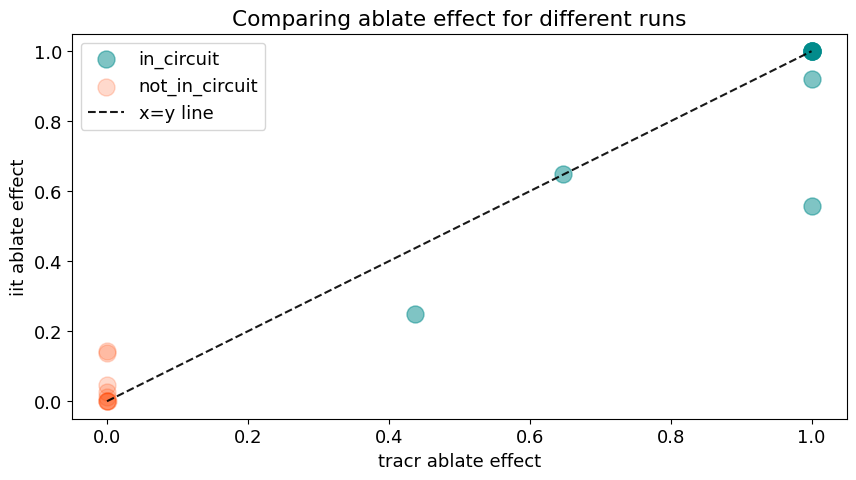

In [62]:
plot_results_in_scatter_plot(df_combined_kl, df_combined_kl_tracr,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=True,
                plot_minmax_lines=False,
                mean=True)

Run 19 does not have not_in_circuit
[0.6469628037270874, 1.0, 1.0, 1.0, 1.0, 0.43732731645159273, 1.0, 1.0, 1.0, 1.0] [0.6166215435441484, 1.0, 0.9932060965888019, 1.0, 1.0, 0.25000007706438926, 1.0, 1.0, 1.0, 1.0] [nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0013136612860038671] [0.11887276865242824, 0.17306650725830383, 0.09429373393923804, 0.1898786585641309, 0.09194832685687832, 7.301964166654053e-08, 0.1733380843546193, 0.1035289089943517, 0.14618186375044828, 0.09440940526617608]
10 10


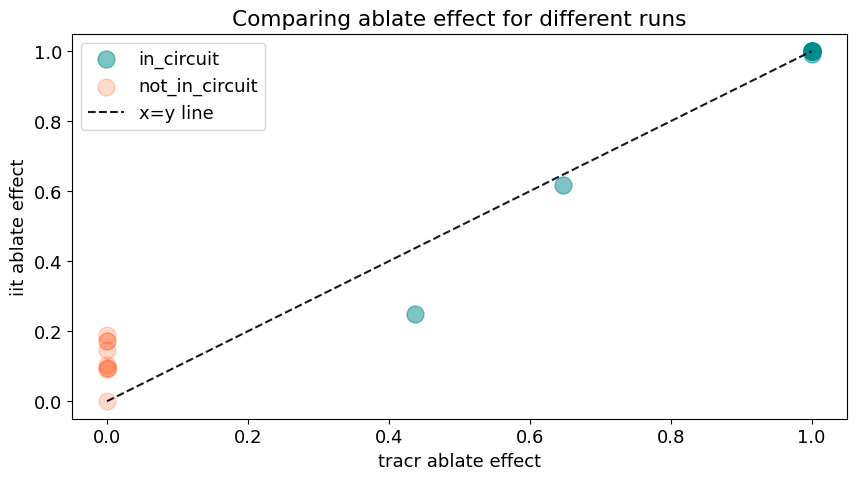

In [63]:
plot_results_in_scatter_plot(df_combined_kl_iit, df_combined_kl_tracr_iit,
                all_cases=all_cases,
                key = "resample_ablate_effect",
                normalize_by_runs=True,
                plot_minmax_lines=False,
                mean=True)